In [ ]:
/content/drive/MyDrive/Applied AI Dataset /creditcard.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

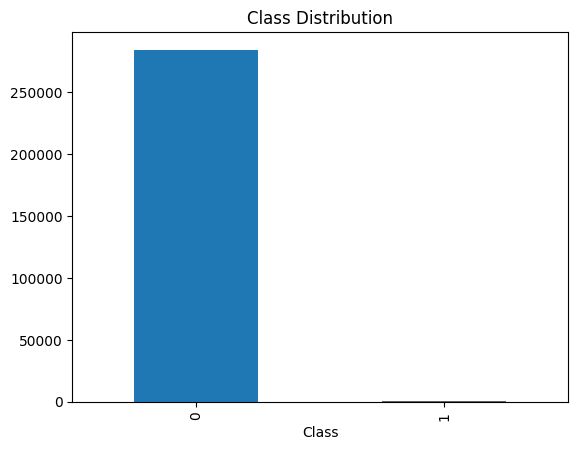

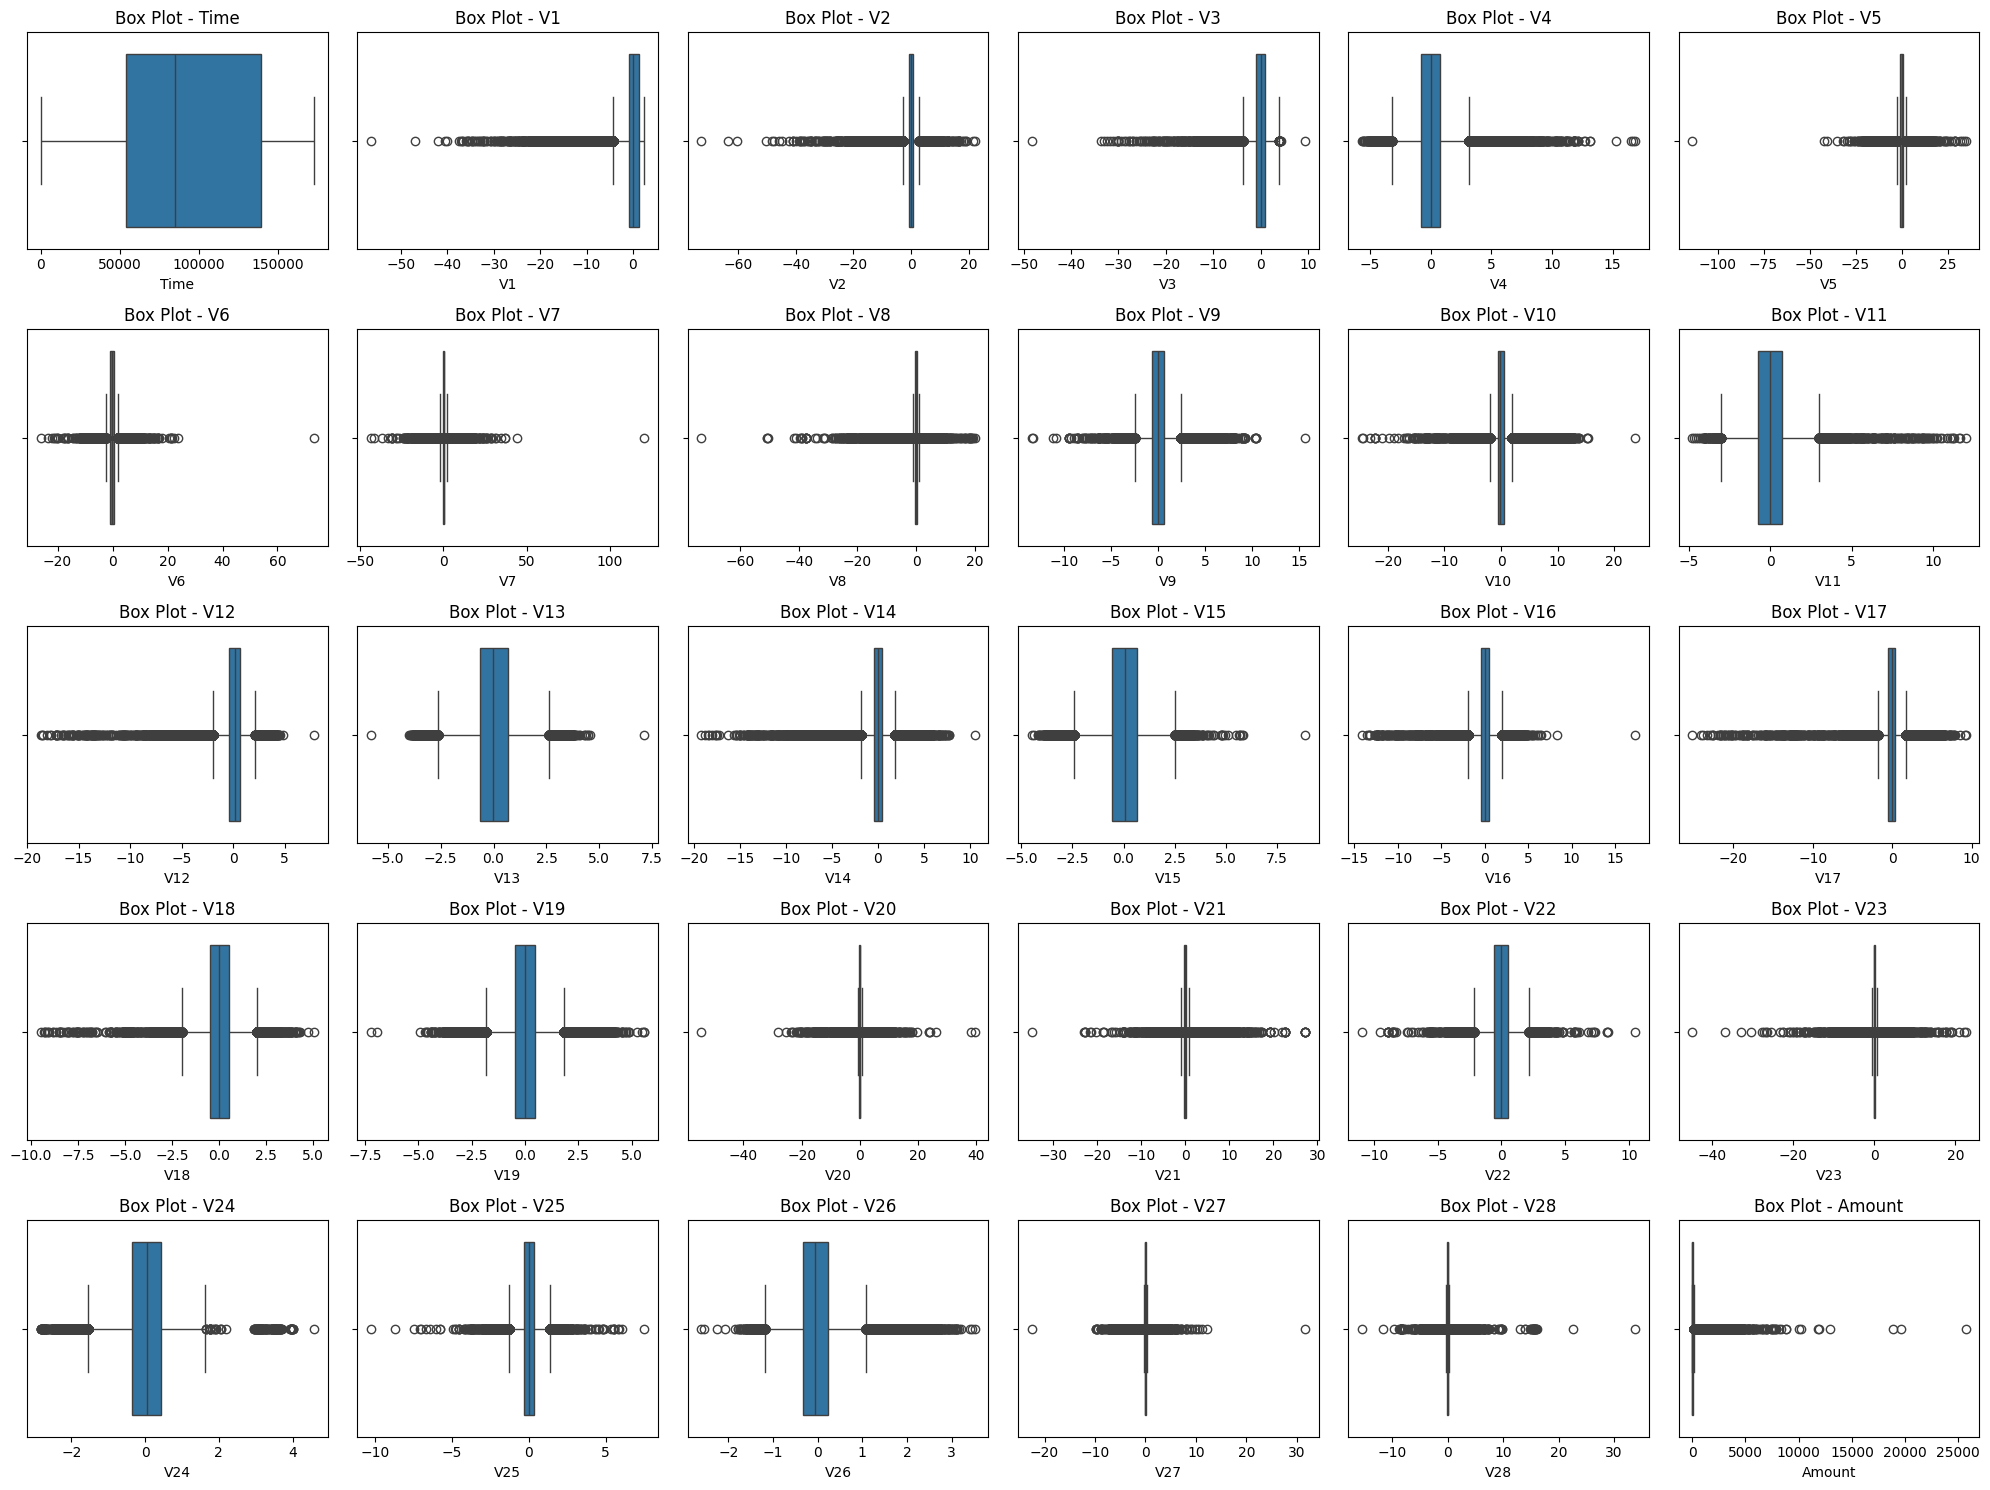

Balanced Class Distribution:
Class
0    170589
1    170589
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/Applied AI Dataset /creditcard.csv'
data = pd.read_csv(file_path)

# View the dataset
print(data.info())
print(data.head())

# Check class distribution
print(data['Class'].value_counts())
data['Class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Visualize box plots for numerical features
# Select numerical features only
numerical_features = data.drop(columns=['Class']).columns

# Draw box plots for each feature
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_features, start=1):
    plt.subplot(5, 6, i)  # Adjust the grid size based on the number of features
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot - {col}')

plt.tight_layout()
plt.show()

# Split features and labels
X = data.drop('Class', axis=1)
y = data['Class']

# Train-test-validation split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for training data balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_resampled, y_train)

# Verify balanced class distribution
print("Balanced Class Distribution:")
print(pd.Series(y_train_balanced).value_counts())


In [ ]:
# EarlyStopping utility to terminate training when validation loss stops improving
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [ ]:
# Transformer model definition with regularization and pooling
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_classes):
        super(TransformerClassifier, self).__init__()
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dropout=0.5)
        self.encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.output = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(0)  # Add sequence dimension
        x = self.encoder(x)
        x = torch.mean(x, dim=0)  # Pooling
        x = self.dropout(torch.relu(self.fc(x)))
        return self.output(x)

    def extract_features(self, x):
        x = x.unsqueeze(0)  # Add sequence dimension
        x = self.encoder(x)
        x = torch.mean(x, dim=0)  # Pooling
        return x


In [ ]:
# Training function for the Transformer model with Early Stopping
def train_transformer(model, train_loader, val_loader, criterion, optimizer, early_stopping, epochs=50):
    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0

        # Training loop
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model checkpoint
    model.load_state_dict(torch.load('checkpoint.pt'))


In [ ]:
# Define dimensions for the Transformer model
input_dim = X_train_balanced.shape[1]
hidden_dim = 64
num_heads = 4
num_classes = 2

# Ensure num_heads is valid
if input_dim % num_heads != 0:
    for i in range(input_dim, 0, -1):
        if input_dim % i == 0:
            num_heads = i
            break

assert input_dim % num_heads == 0, "input_dim must be divisible by num_heads"

# Initialize the Transformer model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = TransformerClassifier(input_dim, hidden_dim, num_heads, num_classes).to(device)

# Loss and optimizer
class_weights = torch.tensor([1.0, 5.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.0005, weight_decay=1e-4)

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Create DataLoaders
train_dataset = TensorDataset(
    torch.tensor(X_train_balanced, dtype=torch.float32),
    torch.tensor(y_train_balanced.values, dtype=torch.long)
)

val_dataset = TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val.values, dtype=torch.long)
)

test_dataset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test.values, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the Transformer model
train_transformer(transformer_model, train_loader, val_loader, criterion, optimizer, early_stopping, epochs=50)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.0352, Validation Loss: 0.0440
Validation loss decreased (inf --> 0.043979). Saving model ...
Epoch 2/50, Train Loss: 0.0123, Validation Loss: 0.0453
EarlyStopping counter: 1 out of 5
Epoch 3/50, Train Loss: 0.0104, Validation Loss: 0.0371
Validation loss decreased (0.043979 --> 0.037104). Saving model ...
Epoch 4/50, Train Loss: 0.0093, Validation Loss: 0.0511
EarlyStopping counter: 1 out of 5
Epoch 5/50, Train Loss: 0.0094, Validation Loss: 0.0344
Validation loss decreased (0.037104 --> 0.034406). Saving model ...
Epoch 6/50, Train Loss: 0.0100, Validation Loss: 0.0431
EarlyStopping counter: 1 out of 5
Epoch 7/50, Train Loss: 0.0090, Validation Loss: 0.0404
EarlyStopping counter: 2 out of 5
Epoch 8/50, Train Loss: 0.0093, Validation Loss: 0.0374
EarlyStopping counter: 3 out of 5
Epoch 9/50, Train Loss: 0.0094, Validation Loss: 0.0449
EarlyStopping counter: 4 out of 5
Epoch 10/50, Train Loss: 0.0089, Validation Loss: 0.0560
EarlyStopping counter: 5 out of 5
Ea

<ipython-input-11-0fde3105a7dc>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


In [ ]:
# Extract features from the trained Transformer model
def extract_features(model, data_loader):
    model.eval()
    features_list = []
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            extracted_features = model.extract_features(features).cpu().numpy()
            features_list.append(extracted_features)
    return np.vstack(features_list)

train_features = extract_features(transformer_model, train_loader)
val_features = extract_features(transformer_model, val_loader)
test_features = extract_features(transformer_model, test_loader)


In [ ]:
# Combine Transformer features with original features
X_train_combined = np.hstack([X_train_balanced, train_features])
X_val_combined = np.hstack([X_val_scaled, val_features])
X_test_combined = np.hstack([X_test_scaled, test_features])

# Train Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
random_forest.fit(X_train_combined, y_train_balanced)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Evaluate the Random Forest model
def evaluate_ensemble_with_metrics(model, X_test_combined, y_test):
    y_pred = model.predict(X_test_combined)
    y_scores = model.predict_proba(X_test_combined)[:, 1]
    auc_roc = roc_auc_score(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    auprc = auc(recall, precision)

    # Confusion Matrix and Classification Report
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test ROC-AUC: {auc_roc:.4f}, Test AUPRC: {auprc:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

evaluate_ensemble_with_metrics(random_forest, X_test_combined, y_test)


Test ROC-AUC: 0.9781, Test AUPRC: 0.8694
Test Accuracy: 0.9995

Confusion Matrix:
[[56849    14]
 [   16    83]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.84      0.85        99

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
import unittest
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Dummy Transformer Classifier (replace with actual import)
class TransformerClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_classes):
        super(TransformerClassifier, self).__init__()
        self.fc = torch.nn.Linear(input_dim, hidden_dim)
        self.output = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return self.output(x)

    def extract_features(self, x):
        return torch.relu(self.fc(x))

# Mock data for testing
np.random.seed(42)
torch.manual_seed(42)
X_mock = np.random.rand(100, 10)  # 100 samples, 10 features
y_mock = np.random.randint(0, 2, size=100)  # Binary classification labels


class TestPipeline(unittest.TestCase):
    # Test Preprocessing Steps
    def test_normalization(self):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_mock)
        self.assertEqual(X_scaled.shape, X_mock.shape)
        self.assertAlmostEqual(np.mean(X_scaled[:, 0]), 0, places=5)

    def test_smote(self):
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_mock, y_mock)
        self.assertGreaterEqual(len(y_resampled[y_resampled == 1]), len(y_mock[y_mock == 1]))

    # Test Transformer Model
    def test_transformer_output_shape(self):
        input_dim = 10
        hidden_dim = 64
        num_heads = 2
        num_classes = 2

        model = TransformerClassifier(input_dim, hidden_dim, num_heads, num_classes)
        dummy_input = torch.rand((32, input_dim))  # Batch size of 32
        output = model(dummy_input)
        self.assertEqual(output.shape, (32, num_classes))

    def test_transformer_feature_extraction(self):
        input_dim = 10
        hidden_dim = 64
        num_heads = 2
        num_classes = 2

        model = TransformerClassifier(input_dim, hidden_dim, num_heads, num_classes)
        dummy_input = torch.rand((32, input_dim))  # Batch size of 32
        features = model.extract_features(dummy_input)
        self.assertEqual(features.shape, (32, hidden_dim))

    # Test Random Forest Classifier
    def test_random_forest_training(self):
        rf = RandomForestClassifier(n_estimators=10, random_state=42)
        rf.fit(X_mock, y_mock)
        predictions = rf.predict(X_mock)
        self.assertEqual(len(predictions), len(y_mock))

    # Test Integration of Pipeline
    def test_pipeline_integration(self):
        input_dim = 10
        hidden_dim = 64
        num_heads = 2
        num_classes = 2

        # Mock Transformer
        transformer = TransformerClassifier(input_dim, hidden_dim, num_heads, num_classes)

        # Mock feature extraction
        transformer_features = np.random.rand(100, hidden_dim)  # Simulate extracted features
        X_combined = np.hstack([X_mock, transformer_features])

        # Train Random Forest on combined features
        rf = RandomForestClassifier(n_estimators=10, random_state=42)
        rf.fit(X_combined, y_mock)
        predictions = rf.predict(X_combined)

        self.assertEqual(len(predictions), len(y_mock))


# Run tests
if __name__ == "__main__":
    unittest.main(argv=[''], verbosity=2, exit=False)


test_normalization (__main__.TestPipeline) ... ok
test_pipeline_integration (__main__.TestPipeline) ... ok
test_random_forest_training (__main__.TestPipeline) ... ok
test_smote (__main__.TestPipeline) ... /usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an err